In [5]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats import multitest
ALPHA=0.01

In [6]:
!mkdir analysis_potentiators

mkdir: cannot create directory ‘analysis_potentiators’: File exists


In [7]:

def qq_plot(df, p_val_column, pval_threshold=None, ylim=None, savefile=None):

    """
    makes a QQ plot of the data
    """

    df = df.sort_values(p_val_column, ascending=False)

    length = len(df)

    increment = 1./length

    expected_p_values = np.arange(1,0,-increment)

    fig = plt.figure(figsize = (5,5))
    ax = fig.gca()
    
    p_val_plot_real = -np.log10(df[p_val_column].astype(float))
    p_val_plot_expected = -np.log10(expected_p_values)[0:len(p_val_plot_real)]
    
    ax.scatter(p_val_plot_expected, p_val_plot_real, s=8, color=df.color)
    ax.plot(p_val_plot_expected, p_val_plot_expected, color="grey")
    
    if pval_threshold:
        ax.axhline(-np.log10(pval_threshold), color="grey")
    
    sns.despine()
    ax.set_xlabel("-log10 expected P values")
    ax.set_ylabel("-log10 real P values")
    if ylim:
        ax.set_ylim(ylim)
    
        upper_bound = ylim[-1]
        n_excluded = sum(p_val_plot_real > upper_bound)
        ax.text(x=1.5,y=upper_bound-1, s=f"{n_excluded} points above axis")
        
    if savefile:
        plt.savefig(savefile)
    
    plt.show()

def create_table(drug):
    association_files = glob.glob(f"output/{drug}_potentiators/2.run_output/*assoc.txt")
    single = pd.read_csv(f"output/{drug}_potentiators/{drug}_mutation_count_table.csv", index_col=0, dtype=object)
    data = pd.DataFrame()
    
    print(f"found {len(association_files)} assoc files")

    for assoc_file in association_files:
        
        d = pd.read_csv(assoc_file, sep="\t", dtype=object, index_col=0, engine="python")
        
        if len(d)==0:
            print("error for", assoc_file)
            continue
            
        # because these are all cross hits, each file contains position i, position j, and cross
        # annotate each entry with the identities of i,j, and cross
        # position j = mutation that happened first (ie, background)
        position_i, position_j = assoc_file.split("/")[-1].split("_")[0:2]
        position_i= str(int(float(position_i)))
        position_j = str(int(float(position_j)))
        _s = single.query("position_i==@position_i and position_j==@position_j")
        
        if (len(_s) ==0):
            print("corrupted file/dataframe", assoc_file, d, position_i, position_j)
            continue
        
        d["N_first"] = list(_s.N_j)[0]
        d["N_second"] = list(_s.N_i)[0]
        d["N_cross"]  = list(_s.N_ij)[0]
        d["first_mutation"] = position_j
        d["second_mutation"] = position_i
        
        data = pd.concat([data, d])

    # Removing duplicate positions
    print("before removing duplicates", len(data))
    data = data.drop_duplicates(subset=["rs", "p_wald", "beta"])
    print("after removing duplicates", len(data))
    
    data["p_wald"] = data["p_wald"].astype(float)
    data = data.sort_values("p_wald").reset_index()
    
    data = data[[
                "rs", "first_mutation", "second_mutation", "n_miss", "af", 
                "beta", 'p_wald', "se", "N_first", "N_second", "N_cross"
            ]]
    
    return data

def add_annotation(data, sequential_annotation_file, potentiator_annotation_file):

    data = data.reset_index()
    # read in for mutations that occur simultaneously or after the initial AB mutation - in this case
    # The known mutation is position_j
    sequential_annotation = pd.read_csv(sequential_annotation_file, dtype=object, engine="python")
    
    data = data.merge(
        sequential_annotation[['position_i', 'gene_name_i', 'position_j', 'gene_name_j']], 
        right_on=["position_i", "position_j"], 
        left_on = ["second_mutation", "first_mutation"],
        how="left"
    )
    
    data.rename(columns={
        "position_i": "test_position", 
        "position_j": "known_position", 
        "gene_name_i": "second_gene_name", 
        "gene_name_j": "first_gene_name"
    }, inplace=True)

    # get those that merged successfully and those that did not
    data_sequential = data.loc[data.test_position.notnull(), :]
    data_sequential["type"] = "sequential"
    print(len(data_sequential))
    data_potentiator = data.loc[data.test_position.isnull(), :]
    data_potentiator["type"] = "potentiator"
    print(len(data_potentiator))
    
    # read in for mutations that occur simultaneously or after the initial AB mutation - in this case
    # The known mutation is position_j
    data_potentiator = data_potentiator.drop(["test_position", "known_position", "second_gene_name", "first_gene_name"], axis=1)
    
    potentiator_annotation = pd.read_csv(potentiator_annotation_file, dtype=object, engine="python")

    data_potentiator = data_potentiator.merge(
        potentiator_annotation[['position_i', 'gene_name_i', 'position_j', 'gene_name_j']], 
        right_on=["position_i", "position_j"], 
        left_on = [ "second_mutation", "first_mutation"],
        how="left"
    )
    
    data_potentiator.rename(columns = {
        "position_j": "test_position", 
        "position_i": "known_position", 
        "gene_name_i": "second_gene_name", 
        "gene_name_j": "first_gene_name"
    }, inplace=True)
    
    data = pd.concat([data_sequential, data_potentiator])
    
    known_positions = set(data.known_position)
    new_positions = set(data.test_position)

    data["known"] = [x in known_positions for x in data.rs]
    data['cross'] = ["_" in x for x in data.rs]

    c1, c2, c3 = "black", "red", "blue"

    data['color'] = None
    for idx, row in data.iterrows():
        if row.known:
            data.loc[idx,'color'] = c1
        elif row.cross:
            data.loc[idx,'color'] = c3
        else:
            data.loc[idx,'color'] = c2
            
    return data

found 857 assoc files
corrupted file/dataframe output/AMIKACIN_potentiators/2.run_output/2715342.0_3841662.0_cross.assoc.txt                       rs  ps n_miss allele1 allele0     af           beta  \
chr                                                                         
-9             2715342.0  -9      7       A    TRUE  0.004   6.404791e-01   
-9             3841662.0  -9     20       A    TRUE  0.044  -9.846506e-02   
-9   2715342.0_3841662.0  -9     26       A    TRUE  0.000   4.727332e-01   

               se        logl_H1       l_remle        p_wald  
chr                                                           
-9   3.943871e-01  -1.873288e+03  7.018279e+02  1.046405e-01  
-9   3.965123e-01  -1.873435e+03  6.975571e+02  8.039231e-01  
-9   1.208147e+00  -1.874556e+03  6.975831e+02  6.956537e-01   2715342 3841662
before removing duplicates 1846
after removing duplicates 728
63
665


/tmp/ipykernel_15863/3170107236.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sequential["type"] = "sequential"
/tmp/ipykernel_15863/3170107236.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_potentiator["type"] = "potentiator"


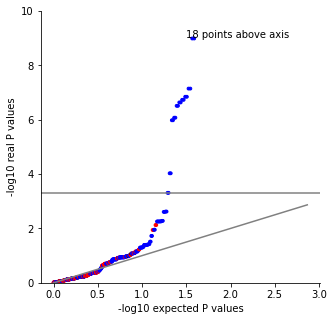

,rs,known_position,test_position,first_mutation,second_mutation,type,beta,p_wald,N_first,N_second,N_cross,first_gene_name,second_gene_name
0,1473246,1473246,3300658,3300658,1473246,potentiator,3.160434e+00,1.459486e-134,32.0,154.0,8.0,fadD29,None
1,1473246.0,1473246,3497859,3497859,1473246,potentiator,3.160434e+00,1.459486e-134,0.0,154.0,0.0,devS,None
2,1473246.0_1287112.0,1473246,1287112,1287112,1473246,potentiator,3.157075e+00,3.207928e-134,1200.0,154.0,154.0,None,None
3,1473246_1287112,1473246,1287112,1287112,1473246,potentiator,3.157075e+00,3.207928e-134,1200.0,154.0,154.0,None,None
4,1473246.0_2626108.0,1473246,2626108,2626108,1473246,potentiator,3.028497e+00,7.776912e-121,1184.0,154.0,146.0,esxO,None
5,1473246_2626108,1473246,2626108,2626108,1473246,potentiator,3.028497e+00,7.776912e-121,1184.0,154.0,146.0,esxO,None
6,1473246_1341040,1473246,1341040,1341040,1473246,potentiator,3.061126e+00,7.921248e-110,1061.0,154.0,137.0,esxL,None
7,1473246.0_1341040.0,1473246,1341040,1341040,1473246,potentiator,3.061126e+00,7.921248e-110,1061.0,154.0,137.0,esxL,None
8,1473246.0_2626191.0,1473246,2626191,2626191,1473246,potentiator,2.973708e+00,9.062100e-109,1172.0,154.0,140.0,None,None
9,1473246_2626191,1473246,2626191,2626191,1473246,potentiator,2.973708e+00,9.062100e-109,1172.0,154.0,140.0,None,None


In [8]:
drug = "AMIKACIN"

data = create_table(drug)
data = add_annotation(data, f"../output/05.antibiotic/AMI_antibiotic_hits.csv",
                      f"../output/05.antibiotic/AMI_potentiator_antibiotic_hits.csv")

## Apply significance cutoffs using BH
data["significant"] = multitest.multipletests(data.p_wald, alpha=ALPHA, method='fdr_bh')[0]
minimum_significant = data.query("significant").p_wald.max()

qq_plot(data, "p_wald", pval_threshold=minimum_significant, ylim=[0,10], savefile=f"analysis_potentiators/{drug}_qq.pdf")

sig = data.query("significant")
data.to_csv(f"analysis_potentiators/{drug}_hit_table.csv")
sig[["rs", "known_position", "test_position", "first_mutation", "second_mutation", "type",
     "beta", "p_wald", "N_first", "N_second", "N_cross", "first_gene_name", "second_gene_name"]]

found 429 assoc files
before removing duplicates 909
after removing duplicates 349
28
321


/tmp/ipykernel_15863/3170107236.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sequential["type"] = "sequential"
/tmp/ipykernel_15863/3170107236.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_potentiator["type"] = "potentiator"


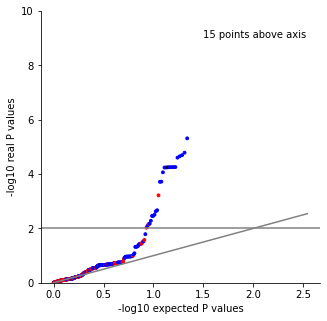

,rs,known_position,test_position,first_mutation,second_mutation,type,beta,p_wald,N_first,N_second,N_cross,first_gene_name,second_gene_name
39,732110,1473246,732110,1473246,732110,sequential,1.161270e+00,8.044625e-03,170.0,8.0,3.0,None,hadA
40,732110_1473246,1473246,732110,1473246,732110,sequential,1.748137e+00,9.378974e-03,170.0,8.0,3.0,None,hadA
0,1473246,1473246,3300658,3300658,1473246,potentiator,2.886292e+00,5.233342e-177,36.0,170.0,10.0,fadD29,None
1,1473246_1287112,1473246,1287112,1287112,1473246,potentiator,2.885623e+00,7.620236e-177,1208.0,170.0,170.0,None,None
2,1473246_2626108,1473246,2626108,2626108,1473246,potentiator,2.824540e+00,2.292357e-156,1199.0,170.0,162.0,esxO,None
3,1473246_2626191,1473246,2626191,2626191,1473246,potentiator,2.751289e+00,3.730451e-133,1187.0,170.0,156.0,None,None
4,1473246_2626189,1473246,2626189,2626189,1473246,potentiator,2.721407e+00,3.937205e-128,1184.0,170.0,155.0,None,None
5,1473246_1341040,1473246,1341040,1341040,1473246,potentiator,2.773475e+00,1.632563e-122,1059.0,170.0,150.0,esxL,None
6,1473246_1341044,1473246,1341044,1341044,1473246,potentiator,2.719438e+00,6.811597e-114,973.0,170.0,149.0,esxL,None
7,1473246_2338994,1473246,2338994,2338994,1473246,potentiator,1.989600e+00,9.373809e-31,883.0,170.0,127.0,Rv2082,None


In [9]:
ALPHA = 0.1
drug = "KANAMYCIN"

data = create_table(drug)

data = add_annotation(data, f"../output/05.antibiotic/KAN_antibiotic_hits.csv", 
                      f"../output/05.antibiotic/KAN_potentiator_antibiotic_hits.csv")

## Apply significance cutoffs using BH
data["significant"] = multitest.multipletests(data.p_wald, alpha=ALPHA, method='fdr_bh')[0]
minimum_significant = data.query("significant").p_wald.max()

qq_plot(data, "p_wald", pval_threshold=minimum_significant, ylim=[0,10], savefile=f"analysis_potentiators/{drug}_qq.pdf")

sig = data.query("significant")
data.to_csv(f"analysis_potentiators/{drug}_hit_table.csv")
sig[["rs", "known_position", "test_position", "first_mutation", "second_mutation", "type",
     "beta", "p_wald", "N_first", "N_second", "N_cross", "first_gene_name", "second_gene_name"]]

found 481 assoc files
before removing duplicates 1185
after removing duplicates 579
129
475


/tmp/ipykernel_15863/3170107236.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sequential["type"] = "sequential"
/tmp/ipykernel_15863/3170107236.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_potentiator["type"] = "potentiator"


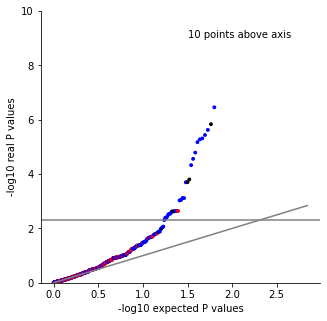

,rs,known_position,test_position,first_mutation,second_mutation,type,beta,p_wald,N_first,N_second,N_cross,first_gene_name,second_gene_name
20,2155168,2155168,3065197,2155168,3065197,sequential,9.511259e-01,1.575547e-04,848.0,0.0,0.0,katG,Rv2752c
23,332951_761110,761110,332951,761110,332951,sequential,1.577086e+00,7.635859e-04,169.0,99.0,52.0,rpoB,vapC25
0,761155,761155,75233,75233,761155,potentiator,2.272281e+00,9.224577e-29,296.0,678.0,136.0,None,rpoB
1,761155_1287112,761155,1287112,1287112,761155,potentiator,2.210062e+00,6.525856e-28,1488.0,678.0,667.0,None,rpoB
2,761155_2626191,761155,2626191,2626191,761155,potentiator,2.085502e+00,1.473228e-26,1461.0,678.0,650.0,None,rpoB
3,761155_2626108,761155,2626108,2626108,761155,potentiator,2.068921e+00,6.061159e-26,1475.0,678.0,655.0,esxO,rpoB
4,761155_2626189,761155,2626189,2626189,761155,potentiator,2.038703e+00,8.291334e-26,1458.0,678.0,648.0,None,rpoB
5,761155_1341040,761155,1341040,1341040,761155,potentiator,1.571457e+00,5.128587e-17,1308.0,678.0,559.0,esxL,rpoB
6,761110,761110,1341285,1341285,761110,potentiator,2.257828e+00,3.736264e-15,1.0,169.0,0.0,esxL,rpoB
7,761110_2626108,761110,2626108,2626108,761110,potentiator,2.168567e+00,2.657726e-14,1475.0,169.0,168.0,esxO,rpoB


In [10]:

drug = "RIFAMPICIN"
annotation_files = []

data = create_table(drug)
data = add_annotation(data, f"../output/05.antibiotic/RIF_antibiotic_hits.csv", f"../output/05.antibiotic/RIF_potentiator_antibiotic_hits.csv")

## Apply significance cutoffs using BH
data["significant"] = multitest.multipletests(data.p_wald, alpha=ALPHA, method='fdr_bh')[0]
minimum_significant = data.query("significant").p_wald.max()

qq_plot(data, "p_wald", pval_threshold=minimum_significant, ylim=[0,10], savefile=f"analysis_potentiators/{drug}_qq.pdf")

sig = data.query("significant")
data.to_csv(f"analysis_potentiators/{drug}_hit_table.csv")
sig[["rs", "known_position", "test_position", "first_mutation", "second_mutation", "type",
     "beta", "p_wald", "N_first", "N_second", "N_cross", "first_gene_name", "second_gene_name"]]

found 290 assoc files
before removing duplicates 656
after removing duplicates 352
168
185


/tmp/ipykernel_15863/3170107236.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sequential["type"] = "sequential"
/tmp/ipykernel_15863/3170107236.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_potentiator["type"] = "potentiator"


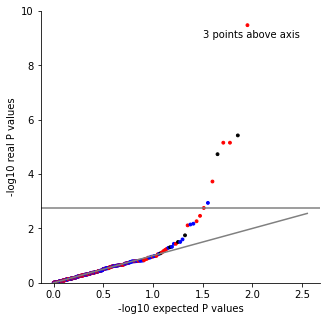

,rs,known_position,test_position,first_mutation,second_mutation,type,beta,p_wald,N_first,N_second,N_cross,first_gene_name,second_gene_name
0,2155168,2155168,4137219,2155168,4137219,sequential,1.992117e+00,1.307646e-22,838.0,2.0,2.0,katG,Rv3695
3,1638364_2155168,2155168,1638364,2155168,1638364,sequential,1.082415e+00,3.323926e-10,838.0,1255.0,698.0,katG,None
7,2123182_2155168,2155168,2123182,2155168,2123182,sequential,1.372000e+00,1.876841e-04,838.0,118.0,96.0,katG,Rv1873
8,332951_2155168,2155168,332951,2155168,332951,sequential,1.421067e+00,1.147673e-03,838.0,99.0,82.0,katG,vapC25
0,2155168_1287112,2155168,1287112,1287112,2155168,potentiator,1.846700e+00,5.812883e-20,1465.0,838.0,827.0,None,katG
1,2155168_1341040,2155168,1341040,1341040,2155168,potentiator,1.299377e+00,1.469425e-13,1290.0,838.0,701.0,esxL,katG
2,1674048,1674048,1674263,1674263,1674048,potentiator,1.492355e+00,3.777089e-06,35.0,27.0,1.0,inhA,fabG1
3,2726141,2155168,2726141,2726141,2155168,potentiator,1.524624e+00,7.007969e-06,58.0,838.0,42.0,None,katG
4,2726141,2155168,2726141,2726141,2155168,potentiator,1.524624e+00,7.007969e-06,58.0,838.0,42.0,None,katG
5,1673425,1673425,1674262,1674262,1673425,potentiator,1.053416e+00,1.855795e-05,6.0,238.0,2.0,inhA,None


In [11]:

drug = "ISONIAZID"


data = create_table(drug)
data = add_annotation(data, f"../output/05.antibiotic/INH_antibiotic_hits.csv", 
                      f"../output/05.antibiotic/INH_potentiator_antibiotic_hits.csv")

## Apply significance cutoffs using BH
data["significant"] = multitest.multipletests(data.p_wald, alpha=ALPHA, method='fdr_bh')[0]
minimum_significant = data.query("significant").p_wald.max()

qq_plot(data, "p_wald", pval_threshold=minimum_significant, ylim=[0,10], savefile=f"analysis_potentiators/{drug}_qq.pdf")

sig = data.query("significant")
data.to_csv(f"analysis_potentiators/{drug}_hit_table.csv")
sig[["rs", "known_position", "test_position", "first_mutation", "second_mutation", "type",
     "beta", "p_wald", "N_first", "N_second", "N_cross", "first_gene_name", "second_gene_name"]]

found 479 assoc files
before removing duplicates 1086
after removing duplicates 455
211
266


/tmp/ipykernel_15863/3170107236.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sequential["type"] = "sequential"
/tmp/ipykernel_15863/3170107236.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_potentiator["type"] = "potentiator"


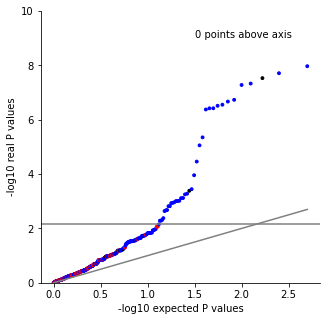

,rs,known_position,test_position,first_mutation,second_mutation,type,beta,p_wald,N_first,N_second,N_cross,first_gene_name,second_gene_name
0,4247429,4247429,4203252,4247429,4203252,sequential,5.585805e-01,1.074432e-08,222.0,0.0,0.0,embB,proW
30,1638364_4247429,4247429,1638364,4247429,1638364,sequential,2.970992e-01,2.104287e-03,222.0,1249.0,164.0,embB,None
35,4243217,4247429,4243217,4247429,4243217,sequential,3.911003e-01,5.181356e-03,222.0,41.0,8.0,embB,None
36,4243217,4247429,4243217,4247429,4243217,sequential,3.911003e-01,5.181356e-03,222.0,41.0,8.0,embB,None
37,4247729,4247729,4088569,4247729,4088569,sequential,3.778647e-01,7.115613e-03,43.0,3.0,2.0,embB,None
0,4247429_1287112,4247429,1287112,1287112,4247429,potentiator,5.459015e-01,1.943555e-08,1456.0,222.0,218.0,None,embB
1,4247431,4247431,2611488,2611488,4247431,potentiator,5.177203e-01,2.949228e-08,17.0,218.0,3.0,Rv2336,embB
2,4247429_2626108,4247429,2626108,2626108,4247429,potentiator,5.304308e-01,4.669956e-08,1443.0,222.0,217.0,esxO,embB
3,4247429_1341040,4247429,1341040,1341040,4247429,potentiator,5.179008e-01,5.270189e-08,1281.0,222.0,201.0,esxL,embB
4,4247429_2626191,4247429,2626191,2626191,4247429,potentiator,5.048462e-01,1.849377e-07,1429.0,222.0,216.0,None,embB


In [12]:

drug = "ETHAMBUTOL"

data = create_table(drug)
data = add_annotation(data, f"../output/05.antibiotic/EMB_antibiotic_hits.csv", 
                      f"../output/05.antibiotic/EMB_potentiator_antibiotic_hits.csv")

## Apply significance cutoffs using BH
data["significant"] = multitest.multipletests(data.p_wald, alpha=ALPHA, method='fdr_bh')[0]
minimum_significant = data.query("significant").p_wald.max()

qq_plot(data, "p_wald", pval_threshold=minimum_significant, ylim=[0,10], savefile=f"analysis_potentiators/{drug}_qq.pdf")

sig = data.query("significant")
data.to_csv(f"analysis_potentiators/{drug}_hit_table.csv")
sig[["rs", "known_position", "test_position", "first_mutation", "second_mutation", "type",
     "beta", "p_wald", "N_first", "N_second", "N_cross", "first_gene_name", "second_gene_name"]]

found 911 assoc files
before removing duplicates 1785
after removing duplicates 553
67
489


/tmp/ipykernel_15863/3170107236.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sequential["type"] = "sequential"
/tmp/ipykernel_15863/3170107236.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_potentiator["type"] = "potentiator"


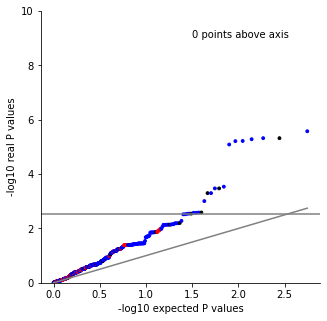

,rs,known_position,test_position,first_mutation,second_mutation,type,beta,p_wald,N_first,N_second,N_cross,first_gene_name,second_gene_name
0,2289213_2338994,2289213,2338994,2338994,2289213,potentiator,1.269288e+00,0.000003,775.0,57.0,52.0,Rv2082,pncA
1,2289213,2289213,3767337,3767337,2289213,potentiator,1.140848e+00,0.000005,0.0,57.0,0.0,None,pncA
2,2289213_1287112,2289213,1287112,1287112,2289213,potentiator,1.140848e+00,0.000005,1104.0,57.0,57.0,None,pncA
3,2289213_2626108,2289213,2626108,2626108,2289213,potentiator,1.136328e+00,0.000005,1096.0,57.0,57.0,esxO,pncA
4,2289213_2626191,2289213,2626191,2626191,2289213,potentiator,1.128689e+00,0.000006,1096.0,57.0,57.0,None,pncA
5,2289213_2626189,2289213,2626189,2626189,2289213,potentiator,1.127714e+00,0.000006,1094.0,57.0,57.0,None,pncA
6,2289213_1341040,2289213,1341040,1341040,2289213,potentiator,1.153422e+00,0.000008,960.0,57.0,54.0,esxL,pncA
7,2289231_1341040,2289231,1341040,1341040,2289231,potentiator,1.208546e+00,0.000291,960.0,13.0,13.0,esxL,pncA
8,2289231_1287112,2289231,1287112,1287112,2289231,potentiator,1.195854e+00,0.000336,1104.0,13.0,13.0,None,pncA
9,2289231,2289231,1287112,1287112,2289231,potentiator,1.195854e+00,0.000336,1104.0,13.0,13.0,None,pncA


In [13]:
drug = "PYRAZINAMIDE"

data = create_table(drug)
data = add_annotation(data, f"../output/05.antibiotic/PZA_antibiotic_hits.csv", f"../output/05.antibiotic/PZA_potentiator_antibiotic_hits.csv")

## Apply significance cutoffs using BH
data["significant"] = multitest.multipletests(data.p_wald, alpha=ALPHA, method='fdr_bh')[0]
minimum_significant = data.query("significant").p_wald.max()

qq_plot(data, "p_wald", pval_threshold=minimum_significant, ylim=[0,10], savefile=f"analysis_potentiators/{drug}_qq.pdf")

sig = data.query("significant")
data.to_csv(f"analysis_potentiators/{drug}_hit_table.csv")
sig[["rs", "known_position", "test_position", "first_mutation", "second_mutation", "type",
     "beta", "p_wald", "N_first", "N_second", "N_cross", "first_gene_name", "second_gene_name"]]

found 585 assoc files
before removing duplicates 1276
after removing duplicates 561
131
432


/tmp/ipykernel_15863/3170107236.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sequential["type"] = "sequential"
/tmp/ipykernel_15863/3170107236.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_potentiator["type"] = "potentiator"


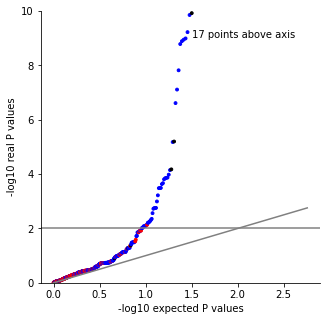

,rs,known_position,test_position,first_mutation,second_mutation,type,beta,p_wald,N_first,N_second,N_cross,first_gene_name,second_gene_name
0,781687,781687,2637920,781687,2637920,sequential,2.279595e+00,6.340025e-34,147.0,0.0,0.0,rpsL,PPE40
0,781687_1287112,781687,1287112,1287112,781687,potentiator,2.284758e+00,1.074223e-33,1456.0,147.0,146.0,None,rpsL
1,781687_1341040,781687,1341040,1341040,781687,potentiator,2.239923e+00,7.073799e-32,1283.0,147.0,141.0,esxL,rpsL
2,781687_1341044,781687,1341044,1341044,781687,potentiator,2.231190e+00,1.023212e-31,1188.0,147.0,141.0,esxL,rpsL
3,781687_2626108,781687,2626108,2626108,781687,potentiator,2.204581e+00,7.041937e-31,1443.0,147.0,142.0,esxO,rpsL
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,781687_1036583,781687,1036583,1036583,781687,potentiator,1.371868e+00,8.308607e-03,36.0,147.0,27.0,pstC2,rpsL
58,781687_787318,781687,787318,787318,781687,potentiator,1.370775e+00,8.359770e-03,36.0,147.0,27.0,Rv0687,rpsL
59,1472359_4060588,1472359,4060588,4060588,1472359,potentiator,9.996530e-01,9.144248e-03,253.0,34.0,20.0,esxW,None
60,1472359_3894732,1472359,3894732,3894732,1472359,potentiator,9.926406e-01,9.663972e-03,220.0,34.0,20.0,PPE60,None


In [14]:
drug = "STREPTOMYCIN"

data = create_table(drug)
data = add_annotation(data, f"../output/05.antibiotic/STM_antibiotic_hits.csv", f"../output/05.antibiotic/STM_potentiator_antibiotic_hits.csv")

## Apply significance cutoffs using BH
data["significant"] = multitest.multipletests(data.p_wald, alpha=ALPHA, method='fdr_bh')[0]
minimum_significant = data.query("significant").p_wald.max()

qq_plot(data, "p_wald", pval_threshold=minimum_significant, ylim=[0,10], savefile=f"analysis_potentiators/{drug}_qq.pdf")

sig = data.query("significant")
data.to_csv(f"analysis_potentiators/{drug}_hit_table.csv")
sig[["rs", "known_position", "test_position", "first_mutation", "second_mutation", "type",
     "beta", "p_wald", "N_first", "N_second", "N_cross", "first_gene_name", "second_gene_name"]]

found 294 assoc files
before removing duplicates 583
after removing duplicates 254
22
232


/tmp/ipykernel_15863/3170107236.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sequential["type"] = "sequential"
/tmp/ipykernel_15863/3170107236.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_potentiator["type"] = "potentiator"


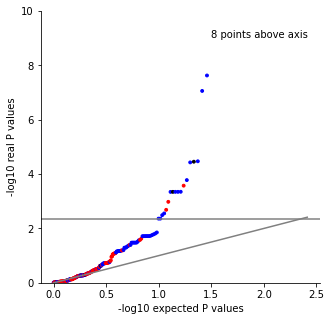

,rs,known_position,test_position,first_mutation,second_mutation,type,beta,p_wald,N_first,N_second,N_cross,first_gene_name,second_gene_name
0,1473246_2626108,1473246,2626108,2626108,1473246,potentiator,1.913222e+00,6.550273e-53,1094.0,136.0,135.0,esxO,None
1,1473246,1473246,3300658,3300658,1473246,potentiator,1.905956e+00,8.738855e-53,36.0,136.0,10.0,fadD29,None
2,1473246_1287112,1473246,1287112,1287112,1473246,potentiator,1.905956e+00,8.738855e-53,1096.0,136.0,136.0,None,None
3,1473246_2626191,1473246,2626191,2626191,1473246,potentiator,1.903830e+00,1.876250e-52,1094.0,136.0,135.0,None,None
4,1473246_2626189,1473246,2626189,2626189,1473246,potentiator,1.886935e+00,3.324288e-51,1092.0,136.0,134.0,None,None
5,1473246_1341040,1473246,1341040,1341040,1473246,potentiator,1.843019e+00,3.521978e-42,951.0,136.0,117.0,esxL,None
6,1473246_1341044,1473246,1341044,1341044,1473246,potentiator,1.773670e+00,8.827551e-38,865.0,136.0,115.0,esxL,None
7,1473246_2338994,1473246,2338994,2338994,1473246,potentiator,1.679936e+00,2.131918e-24,786.0,136.0,98.0,Rv2082,None
8,1473246_1276588,1473246,1276588,1276588,1473246,potentiator,1.177703e+00,2.356328e-08,328.0,136.0,48.0,Rv1148c,None
9,1473246_2122395,1473246,2122395,2122395,1473246,potentiator,1.149936e+00,8.725127e-08,256.0,136.0,53.0,lldD2,None


In [15]:
drug = "CAPREOMYCIN"

data = create_table(drug)
data = add_annotation(data, f"../output/05.antibiotic/CAP_antibiotic_hits.csv", f"../output/05.antibiotic/CAP_potentiator_antibiotic_hits.csv")

## Apply significance cutoffs using BH
data["significant"] = multitest.multipletests(data.p_wald, alpha=ALPHA, method='fdr_bh')[0]
minimum_significant = data.query("significant").p_wald.max()

qq_plot(data, "p_wald", pval_threshold=minimum_significant, ylim=[0,10], savefile=f"analysis_potentiators/{drug}_qq.pdf")

sig = data.query("significant")
data.to_csv(f"analysis_potentiators/{drug}_hit_table.csv")
sig[["rs", "known_position", "test_position", "first_mutation", "second_mutation", "type",
     "beta", "p_wald", "N_first", "N_second", "N_cross", "first_gene_name", "second_gene_name"]]

found 185 assoc files
before removing duplicates 248
after removing duplicates 113
27
86


/tmp/ipykernel_15863/3170107236.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sequential["type"] = "sequential"
/tmp/ipykernel_15863/3170107236.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_potentiator["type"] = "potentiator"


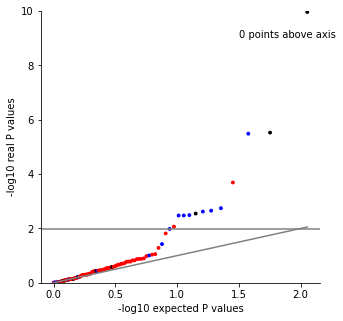

,rs,known_position,test_position,first_mutation,second_mutation,type,beta,p_wald,N_first,N_second,N_cross,first_gene_name,second_gene_name
5,1532777_1674481,1674481,1532777,1674481,1532777,sequential,9.873782e-01,2.214362e-03,27.0,225.0,13.0,inhA,PPE19
0,1673425,1673425,1674262,1674262,1673425,potentiator,8.491287e-01,1.087603e-10,5.0,202.0,1.0,inhA,None
1,1674481,1674481,4385937,4385937,1674481,potentiator,1.141944e+00,2.978756e-06,3.0,27.0,0.0,Rv3900c,inhA
2,1674481_2030521,1674481,2030521,2030521,1674481,potentiator,1.137506e+00,3.263263e-06,1204.0,27.0,27.0,esxM,inhA
3,1674263,1674048,1674263,1674263,1674048,potentiator,9.315934e-01,2.041322e-04,35.0,25.0,1.0,inhA,fabG1
4,1673425_1674263,1673425,1674263,1674263,1673425,potentiator,8.062872e-01,1.797954e-03,35.0,202.0,34.0,inhA,None
5,1674481_2829918,1674481,2829918,2829918,1674481,potentiator,1.259219e+00,2.393973e-03,168.0,27.0,8.0,None,inhA
6,1674048,1674048,1674263,1674263,1674048,potentiator,6.872210e-01,2.838585e-03,35.0,25.0,1.0,inhA,fabG1
7,1673425_1674782,1673425,1674782,1674782,1673425,potentiator,2.194741e+00,3.233475e-03,4.0,202.0,2.0,inhA,None
8,1674481_2338990,1674481,2338990,2338990,1674481,potentiator,1.070822e+00,3.334994e-03,883.0,27.0,13.0,Rv2082,inhA


In [16]:
drug = "ETHIONAMIDE"

data = create_table(drug)
data = add_annotation(data, f"../output/05.antibiotic/ETA_antibiotic_hits.csv", f"../output/05.antibiotic/ETA_potentiator_antibiotic_hits.csv")

## Apply significance cutoffs using BH
data["significant"] = multitest.multipletests(data.p_wald, alpha=ALPHA, method='fdr_bh')[0]
minimum_significant = data.query("significant").p_wald.max()

qq_plot(data, "p_wald", pval_threshold=minimum_significant, ylim=[0,10], savefile=f"analysis_potentiators/{drug}_qq.pdf")

sig = data.query("significant")
data.to_csv(f"analysis_potentiators/{drug}_hit_table.csv")
sig[["rs", "known_position", "test_position", "first_mutation", "second_mutation", "type",
     "beta", "p_wald", "N_first", "N_second", "N_cross", "first_gene_name", "second_gene_name"]]

found 244 assoc files
before removing duplicates 586
after removing duplicates 260
7
256


/tmp/ipykernel_15863/3170107236.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sequential["type"] = "sequential"
/tmp/ipykernel_15863/3170107236.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_potentiator["type"] = "potentiator"


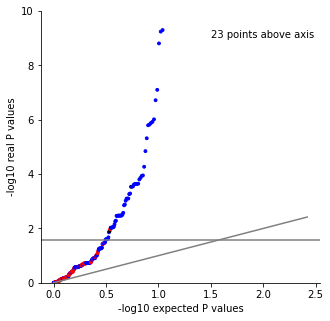

,rs,known_position,test_position,first_mutation,second_mutation,type,beta,p_wald,N_first,N_second,N_cross,first_gene_name,second_gene_name
0,7582_2626191,7582,2626191,2626191,7582,potentiator,2.296313e+00,1.293079e-31,1065.0,58.0,53.0,None,gyrA
1,7582_2626189,7582,2626189,2626189,7582,potentiator,2.271528e+00,1.306782e-31,1062.0,58.0,54.0,None,gyrA
2,7582,7582,3074408,3074408,7582,potentiator,2.174443e+00,4.652318e-30,1.0,58.0,1.0,thyA,gyrA
3,7582_1287112,7582,1287112,1287112,7582,potentiator,2.174709e+00,4.669367e-30,1088.0,58.0,58.0,None,gyrA
4,7582_2626108,7582,2626108,2626108,7582,potentiator,2.172131e+00,8.598076e-30,1077.0,58.0,56.0,esxO,gyrA
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,7570_4060588,7570,4060588,4060588,7570,potentiator,8.006489e-01,2.419587e-02,164.0,39.0,19.0,esxW,gyrA
80,7570_1722228,7570,1722228,1722228,7570,potentiator,7.967264e-01,2.485686e-02,154.0,39.0,19.0,pks5,gyrA
81,7581_2986827,7581,2986827,2986827,7581,potentiator,2.587870e+00,2.518513e-02,22.0,17.0,1.0,Rv2670c,gyrA
82,7570_75233,7570,75233,75233,7570,potentiator,7.951360e-01,2.521100e-02,173.0,39.0,19.0,None,gyrA


In [17]:
drug = "MOXIFLOXACIN"

data = create_table(drug)
data = add_annotation(data, f"../output/05.antibiotic/MOXI_antibiotic_hits.csv", f"../output/05.antibiotic/MOXI_potentiator_antibiotic_hits.csv")

## Apply significance cutoffs using BH
data["significant"] = multitest.multipletests(data.p_wald, alpha=ALPHA, method='fdr_bh')[0]
minimum_significant = data.query("significant").p_wald.max()

qq_plot(data, "p_wald", pval_threshold=minimum_significant, ylim=[0,10], savefile=f"analysis_potentiators/{drug}_qq.pdf")

sig = data.query("significant")
data.to_csv(f"analysis_potentiators/{drug}_hit_table.csv")
sig[["rs", "known_position", "test_position", "first_mutation", "second_mutation", "type",
     "beta", "p_wald", "N_first", "N_second", "N_cross", "first_gene_name", "second_gene_name"]]

### Detailed analysis of which results were found per drug

In [18]:
files = glob.glob("analysis_potentiators/*hit_table.csv")

all_first_mutations = []
for file in files:
    print(file)
    table = pd.read_csv(file, index_col = 0)
    
    table = table.query("significant")
    table["known"] = table["rs"].astype(str)==table["known_position"].astype(str)
    
    potentiators = table.query("type=='potentiator' and not known")
    potentiators_single = potentiators.drop_duplicates(["first_mutation", "first_gene_name"])
    #print(potentiators_single.sort_values("first_mutation")[["first_mutation", "first_gene_name"]])
    for idx, row in potentiators_single.iterrows():
        all_first_mutations.append(f"{int(row.first_mutation)}_{row.first_gene_name}")
    
# construct a matrix on a drug, frist mutation basis
all_first_mutations = sorted(list(set(all_first_mutations)))

mat = np.zeros(shape=(len(files), len(all_first_mutations)))
drug_list = []
for idx,file in enumerate(files):
    #print(file)
    drug = file.split("/")[-1].split("_hit_table.csv")[0]
    drug_list.append(drug)
    table = pd.read_csv(file, index_col = 0)
    
    table = table.query("significant")
    table["known"] = table["rs"].astype(str)==table["known_position"].astype(str)
    
    potentiators = table.query("type=='potentiator' and not known")
    potentiators_single = potentiators.drop_duplicates(["first_mutation", "first_gene_name"])
    
    potentiators_single = potentiators.drop_duplicates(["first_mutation", "first_gene_name"])
    #print(potentiators_single.sort_values("first_mutation")[["first_mutation", "first_gene_name"]])
    for _, row in potentiators_single.iterrows():
        jdx = all_first_mutations.index(f"{int(row.first_mutation)}_{row.first_gene_name}")
        #print(idx, jdx)
        if row.cross:
            mat[idx, jdx] += 2
        else:
            #print(row)
            mat[idx, jdx] += 1

analysis_potentiators/KANAMYCIN_hit_table.csv
analysis_potentiators/AMIKACIN_hit_table.csv
analysis_potentiators/CAPREOMYCIN_hit_table.csv
analysis_potentiators/MOXIFLOXACIN_hit_table.csv
analysis_potentiators/ETHIONAMIDE_hit_table.csv
analysis_potentiators/ISONIAZID_hit_table.csv
analysis_potentiators/STREPTOMYCIN_hit_table.csv
analysis_potentiators/PYRAZINAMIDE_hit_table.csv
analysis_potentiators/RIFAMPICIN_hit_table.csv
analysis_potentiators/ETHAMBUTOL_hit_table.csv


<AxesSubplot:>

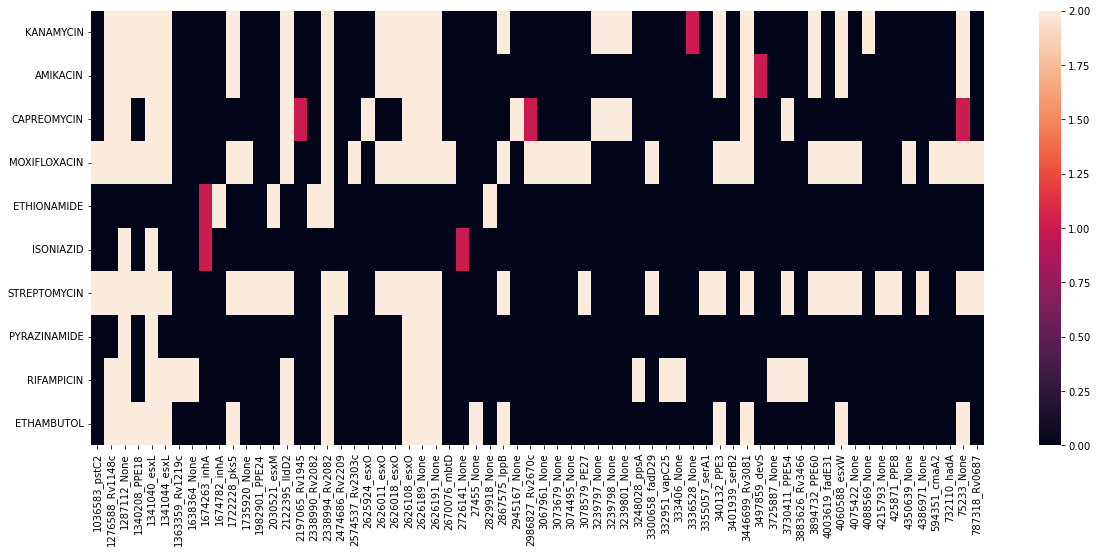

In [19]:
figure = plt.figure(figsize=(20,8))
sns.heatmap(mat,xticklabels=all_first_mutations, yticklabels =drug_list)


In [20]:
files = glob.glob("analysis_potentiators/*hit_table.csv")

combined_results = []

for file in files:
    print(file)
    drug = file.split("/")[-1].split("_hit_table.csv")[0]
    table = pd.read_csv(file, index_col = 0)
    table["drug"] = drug
    table = table.query("significant")
    table["known"] = table["rs"].astype(str)==table["known_position"].astype(str)
    
    potentiators = table.query("type=='sequential' and not known")
    potentiators_single = potentiators.drop_duplicates(["rs", "second_mutation", "second_gene_name"])
    combined_results.append(potentiators_single)
    
combined_results = pd.concat(combined_results)

analysis_potentiators/KANAMYCIN_hit_table.csv
analysis_potentiators/AMIKACIN_hit_table.csv
analysis_potentiators/CAPREOMYCIN_hit_table.csv
analysis_potentiators/MOXIFLOXACIN_hit_table.csv
analysis_potentiators/ETHIONAMIDE_hit_table.csv
analysis_potentiators/ISONIAZID_hit_table.csv
analysis_potentiators/STREPTOMYCIN_hit_table.csv
analysis_potentiators/PYRAZINAMIDE_hit_table.csv
analysis_potentiators/RIFAMPICIN_hit_table.csv
analysis_potentiators/ETHAMBUTOL_hit_table.csv


In [21]:
combined_results[['rs', 'first_mutation', 'second_mutation', 'drug',
       'beta', 'p_wald', 'N_first', 'N_second', 'N_cross',
       'test_position', 'second_gene_name', 'known_position',
       'first_gene_name', 
]]

,rs,first_mutation,second_mutation,drug,beta,p_wald,N_first,N_second,N_cross,test_position,second_gene_name,known_position,first_gene_name
39,732110,1473246,732110,KANAMYCIN,1.161270,8.044625e-03,170.0,8.0,3.0,732110,hadA,1473246,None
40,732110_1473246,1473246,732110,KANAMYCIN,1.748137,9.378974e-03,170.0,8.0,3.0,732110,hadA,1473246,None
5,1532777_1674481,1674481,1532777,ETHIONAMIDE,0.987378,2.214362e-03,27.0,225.0,13.0,1532777,PPE19,1674481,inhA
3,1638364_2155168,2155168,1638364,ISONIAZID,1.082415,3.323926e-10,838.0,1255.0,698.0,1638364,None,2155168,katG
7,2123182_2155168,2155168,2123182,ISONIAZID,1.372000,1.876841e-04,838.0,118.0,96.0,2123182,Rv1873,2155168,katG
8,332951_2155168,2155168,332951,ISONIAZID,1.421067,1.147673e-03,838.0,99.0,82.0,332951,vapC25,2155168,katG
23,332951_761110,761110,332951,RIFAMPICIN,1.577086,7.635859e-04,169.0,99.0,52.0,332951,vapC25,761110,rpoB
30,1638364_4247429,4247429,1638364,ETHAMBUTOL,0.297099,2.104287e-03,222.0,1249.0,164.0,1638364,None,4247429,embB
35,4243217,4247429,4243217,ETHAMBUTOL,0.391100,5.181356e-03,222.0,41.0,8.0,4243217,None,4247429,embB


## Of the 20 potentiating mutations found, what fraction have an epistatic hit? 

In [22]:
potentiators_20 = pd.read_csv("../output/potentiator_mutations.csv", index_col = 0)
potentiators_20

,Unnamed: 0,pos,ref,alt,gene_id,gene_pos,gene_category,gene_name,is_lineage
201,20051,75233,C,['A'],intergenic,NaN,None,None,False
489,73834,340132,G,['A'],Rv0280,768.0,PE/PPE,PPE3,False
632,95481,454333,T,['G'],Rv0376c,1103.0,Non-Essential,Rv0376c,False
1491,239536,1276588,C,['G'],Rv1148c,288.0,Non-Essential,Rv1148c,False
1512,241057,1287112,T,['C'],intergenic,NaN,None,None,False
1598,250896,1340208,G,['A'],Rv1196,859.0,PE/PPE,PPE18,False
1620,251012,1341040,C,"['A', 'T']",Rv1198,34.0,Antigen,esxL,False
1621,251014,1341044,C,['T'],Rv1198,38.0,Antigen,esxL,False
2011,315778,1722228,A,"['C', 'T', 'G']",Rv1527c,145.0,Non-Essential,pks5,False
2353,384755,2122395,C,['T'],Rv1872c,488.0,Antigen,lldD2,False


In [23]:
files = glob.glob("analysis_potentiators/*hit_table.csv")

potentiators_list = list(potentiators_20.pos)
num_drugs_epistatic = np.zeros(len(potentiators_list))

all_first_mutations = []
for file in files:
    table = pd.read_csv(file, index_col = 0)
    
    table = table.query("significant")
    table["known"] = table["rs"].astype(str)==table["known_position"].astype(str)
    
    potentiators = table.query("type=='potentiator' and not known")
    potentiators_single = potentiators.drop_duplicates(["first_mutation", "first_gene_name"])
    #print(potentiators_single.sort_values("first_mutation")[["first_mutation", "first_gene_name"]])
    for idx, row in potentiators_single.iterrows():
        all_first_mutations.append(int(row.first_mutation))
        if int(row.first_mutation) in potentiators_list:
            i = potentiators_list.index(int(row.first_mutation))
            num_drugs_epistatic[i] += 1
        


In [24]:
x = pd.DataFrame({"pos":potentiators_list, "num_drugs":num_drugs_epistatic})
potentiators_20 = potentiators_20.merge(x, on="pos", how="left")
potentiators_20

,Unnamed: 0,pos,ref,alt,gene_id,gene_pos,gene_category,gene_name,is_lineage,num_drugs
0,20051,75233,C,['A'],intergenic,NaN,None,None,False,6.0
1,73834,340132,G,['A'],Rv0280,768.0,PE/PPE,PPE3,False,5.0
2,95481,454333,T,['G'],Rv0376c,1103.0,Non-Essential,Rv0376c,False,0.0
3,239536,1276588,C,['G'],Rv1148c,288.0,Non-Essential,Rv1148c,False,7.0
4,241057,1287112,T,['C'],intergenic,NaN,None,None,False,9.0
5,250896,1340208,G,['A'],Rv1196,859.0,PE/PPE,PPE18,False,5.0
6,251012,1341040,C,"['A', 'T']",Rv1198,34.0,Antigen,esxL,False,9.0
7,251014,1341044,C,['T'],Rv1198,38.0,Antigen,esxL,False,7.0
8,315778,1722228,A,"['C', 'T', 'G']",Rv1527c,145.0,Non-Essential,pks5,False,5.0
9,384755,2122395,C,['T'],Rv1872c,488.0,Antigen,lldD2,False,7.0


In [25]:
epistatic_potentiators = set(all_first_mutations)
potentiators = set(potentiators_20.pos)

print(len(potentiators.intersection(epistatic_potentiators)))

19


In [26]:
potentiators_list

[75233,
 340132,
 454333,
 1276588,
 1287112,
 1340208,
 1341040,
 1341044,
 1722228,
 2122395,
 2338994,
 2626011,
 2626018,
 2626108,
 2626189,
 2626191,
 2867575,
 3446699,
 3894732,
 4060588]

In [31]:
combined_results = []
for file in files:
    print(file)
    drug = file.split("/")[-1].split("_hit_table.csv")[0]
    table = pd.read_csv(file, index_col = 0)
    table["drug"] = drug
    #table = table.query("significant")
    table["known"] = table["rs"].astype(str)==table["known_position"].astype(str)

    combined_results.append(table)
    
combined_results = pd.concat(combined_results)

analysis_potentiators/KANAMYCIN_hit_table.csv
analysis_potentiators/AMIKACIN_hit_table.csv
analysis_potentiators/CAPREOMYCIN_hit_table.csv
analysis_potentiators/MOXIFLOXACIN_hit_table.csv
analysis_potentiators/ETHIONAMIDE_hit_table.csv
analysis_potentiators/ISONIAZID_hit_table.csv
analysis_potentiators/STREPTOMYCIN_hit_table.csv
analysis_potentiators/PYRAZINAMIDE_hit_table.csv
analysis_potentiators/RIFAMPICIN_hit_table.csv
analysis_potentiators/ETHAMBUTOL_hit_table.csv


In [33]:
combined_results.drop_duplicates("rs")

,index,rs,first_mutation,second_mutation,n_miss,af,beta,p_wald,se,N_first,...,test_position,second_gene_name,known_position,first_gene_name,type,known,cross,color,significant,drug
39,39,732110,1473246,732110,45,0.003,1.161270,0.008045,0.437459,170.0,...,732110,hadA,1473246,None,sequential,False,False,blue,True,KANAMYCIN
40,40,732110_1473246,1473246,732110,73,0.001,1.748137,0.009379,0.671824,170.0,...,732110,hadA,1473246,None,sequential,False,True,red,True,KANAMYCIN
47,47,853231_1473246,1473246,853231,35,0.005,0.654871,0.037335,0.314182,170.0,...,853231,phoR,1473246,None,sequential,False,True,blue,False,KANAMYCIN
48,48,853231,1473246,853231,6,0.005,0.647130,0.039666,0.314228,170.0,...,853231,phoR,1473246,None,sequential,False,False,blue,False,KANAMYCIN
66,66,3568759,781687,3568759,0,0.000,1.622876,0.113927,1.025887,99.0,...,3568759,None,781687,rpsL,sequential,False,False,blue,False,KANAMYCIN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,446,4247429_3078579,3078579,4247429,14,0.005,0.004392,0.984902,0.232066,63.0,...,3078579,embB,4247429,PE27,potentiator,False,True,blue,False,ETHAMBUTOL
284,447,4247429_4075422,4075422,4247429,12,0.005,0.003794,0.986958,0.232058,64.0,...,4075422,embB,4247429,None,potentiator,False,True,blue,False,ETHAMBUTOL
286,449,4247431_27455,27455,4247431,74,0.004,-0.003748,0.988232,0.254060,58.0,...,27455,embB,4247431,None,potentiator,False,True,blue,False,ETHAMBUTOL
287,450,4247429_1161026,1161026,4247429,27,0.001,-0.008552,0.989535,0.651888,6.0,...,1161026,embB,4247429,esxJ,potentiator,False,True,blue,False,ETHAMBUTOL
